<font size = "5"> **[Image Tools](2_Image_Tools.ipynb)** </font>

<hr style="height:2px;border-top:4px solid #FF8200" />


#  Analyzing Ring Diffraction Pattern


[<img src=https://www.coeuscreativegroup.com/wp-content/uploads/2020/04/download-button.png, width=125>](https://raw.githubusercontent.com/pycroscopy/pyTEMlib/main/notebooks/Imaging/Adaptive_Fourier_Filter.ipynb) 

[![OpenInColab](https://colab.research.google.com/assets/colab-badge.svg)](
    https://colab.research.google.com/github/pycroscopy/pyTEMlib/blob/main/notebooks/Imaging/Adaptive_Fourier_Filter.ipynb)
    
    

part of 

<font size = "5"> **[pyTEMlib](https://pycroscopy.github.io/pyTEMlib/about.html)**</font>

a [pycroscopy](https://pycroscopy.github.io/pycroscopy/about.html) ecosystem package


Notebook by Gerd Duscher, 2025

Microscopy Facilities<br>
Institute of Advanced Materials & Manufacturing<br>
The University of Tennessee, Knoxville

Model based analysis and quantification of data acquired with transmission electron microscopes


## Content

An introduction into **diffraction_tools** and how to use the functions in this package to 
index ring diffraction pattern of polycrystalline samples.

The scope of this notebook includes calculation and plotting of 
- scattering profiles,
- publication quality figure.
  
An explanation on the physcial background can be found in the *Diffraction* chapter of MSE672-Introduction to TEM


## Install pyTEMlib

If you have not done so in the [Introduction Notebook](../0_pyTEMlib.ipynb), please test and install [pyTEMlib](https://github.com/pycroscopy/pyTEMlib) and other important packages with the code cell below.



## Load relevant python packages
### Check Installed Packages

In [ ]:
import sys
import importlib.metadata
def test_package(package_name):
    """Test whether package exists and returns version or -1"""
    try:
        version = importlib.metadata.version(package_name)
    except importlib.metadata.PackageNotFoundError:
        version = '-1'
    return version

if test_package('pyTEMlib') < '0.2025.12.0':
    print('installing pyTEMlib')
    !{sys.executable} -m pip install git+https://github.com/pycroscopy/pyTEMlib.git@main -q --upgrade

print('done')

### Load the plotting and figure packages
Import the python packages that we will use:

Beside the basic numerical (numpy) and plotting (pylab of matplotlib) libraries,
* three dimensional plotting
and some libraries from the book
* kinematic scattering library.

In [1]:
%matplotlib  widget
import os
import sys

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

if 'google.colab' in sys.modules:
    from google.colab import output
    from google.colab import drive
    output.enable_custom_widget_manager()

# Import microscopt library
sys.path.insert(0, os.path.abspath("../../"))  # point to the pyTEMlib location
%load_ext autoreload
%autoreload 2
import pyTEMlib
    
# it is a good idea to show the version numbers at this point for archiving reasons.
__notebook_version__ = '2025.12.06'
print('pyTEM version: ', pyTEMlib.__version__)
print('notebook version: ', __notebook_version__)

pyTEM version:  0.2025.12.1
notebook version:  2025.12.06



## Load Ring-Diffraction Pattern
### First we select the diffraction pattern

Load the **GOLD-NP-DIFF.dm3** file as an example.
  
The dynamic range of diffraction patterns is too high for computer screens and so we take the logarithm of the intensity. 

In [2]:
# ------Input -------------
load_your_own_data = False
# -------------------------
if 'google.colab' in sys.modules:
        drive.mount("/content/drive")

if load_your_own_data:
    fileWidget = pyTEMlib.file_tools.FileWidget()

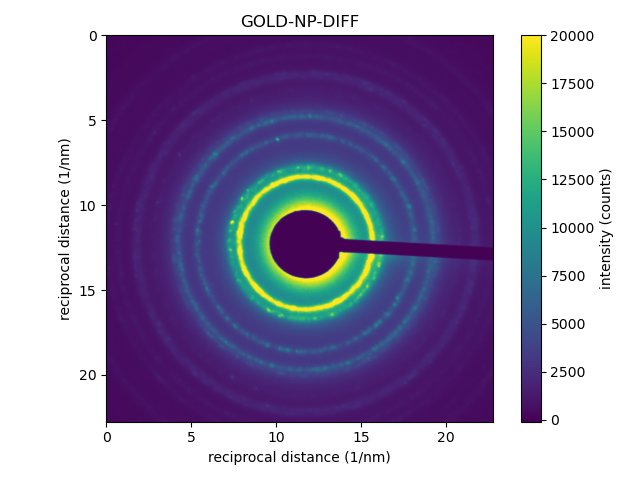

C:\Users\gduscher\AppData\Local\anaconda3\Lib\site-packages\dask\_task_spec.py:759: RuntimeWarning: divide by zero encountered in log
  return self.func(*new_argspec)
C:\Users\gduscher\AppData\Local\anaconda3\Lib\site-packages\dask\_task_spec.py:759: RuntimeWarning: invalid value encountered in log
  return self.func(*new_argspec)
C:\Users\gduscher\AppData\Local\anaconda3\Lib\site-packages\dask\_task_spec.py:759: RuntimeWarning: divide by zero encountered in log2
  return self.func(*new_argspec)
C:\Users\gduscher\AppData\Local\anaconda3\Lib\site-packages\dask\_task_spec.py:759: RuntimeWarning: invalid value encountered in log2
  return self.func(*new_argspec)
C:\Users\gduscher\AppData\Local\anaconda3\Lib\site-packages\dask\_task_spec.py:759: RuntimeWarning: divide by zero encountered in log2
  return self.func(*new_argspec)
C:\Users\gduscher\AppData\Local\anaconda3\Lib\site-packages\dask\_task_spec.py:759: RuntimeWarning: invalid value encountered in log2
  return self.func(*new_argspe

In [3]:
if load_your_own_data:
    datasets = fileWidget.datasets
    main_dataset = fileWidget.selected_dataset
else:  # load example
    datasets = pyTEMlib.file_tools.open_file(os.path.join("../../example_data", "GOLD-NP-DIFF.dm3"))
    main_dataset =  datasets['Channel_000']

view = main_dataset.plot(vmax=20000)

## Finding the center

### Select the center yourself

If there is a beam stop, the center is hard to find, use the selection to get center.
    
Cross correlation and auto correlation are based on a  multiplication in Fourier space. In the case of a an auto-correlation it is the same data while in the cross correlation it is another data (here the transposed (rotated) diffraction pattern)"

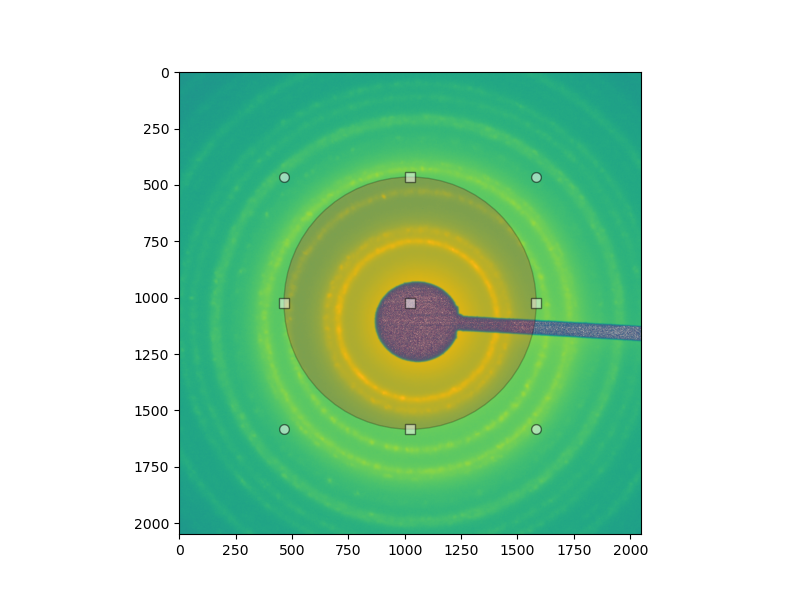

In [4]:

center = np.array(main_dataset.shape)/2

plt.figure(figsize=(8, 6))
plt.imshow(np.log(3.+main_dataset).T, origin = 'upper')
# gca get current axis (plot)
selector = matplotlib.widgets.EllipseSelector(plt.gca(), None,interactive=True )
# selector.to_draw.set_visible(True)
radius = 559 
center = np.array(center)

selector.extents = (center[0]-radius,center[0]+radius,center[1]-radius,center[1]+radius)

Get center coordinates from selection

In [6]:
xmin, xmax, ymin, ymax = selector.extents
x_center, y_center = selector.center
x_shift = x_center - main_dataset.shape[0]/2
y_shift = y_center - main_dataset.shape[1]/2
print(f'radius = {(xmax-xmin)/2:.0f} pixels')

center = (x_center, y_center)
print(f'center = {center[0]:.1f}, {center[1]:.1f} [pixels]')


radius = 559 pixels
center = 1059.5, 1103.8 [pixels]


## Ploting Diffraction Pattern in Polar Coordinates",

### The Transformation Routine

We use the polar transformation routine of scipy-image (skimage) **skimage.transform.warp_polar**

If the center is correct a ring in carthesian coordinates is a line in polar coordinates

### Diffraction Profile

A simple sum over all angles gives us then the diffraction profile (intensity profile of diffraction pattern)


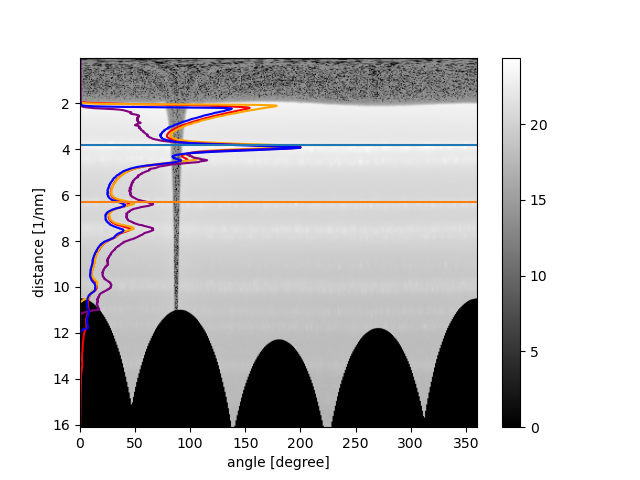

In [7]:
tags = pyTEMlib.diffraction_tools.scattering_profiles(main_dataset, center)

# ###################
# Make some profiles
# ###################
profile_0 = tags['polar_projection'][:,0:10].sum(axis=1)
profile_0 += tags['polar_projection'][:,350:360].sum(axis=1)
profile_180 = tags['polar_projection'][:,190:210].sum(axis=1)
profile_270 = tags['polar_projection'][:,260:280].sum(axis=1)
profile_90 = tags['polar_projection'][:,80:100].sum(axis=1)

# ############### 
# Plot

scale = main_dataset.get_image_dims(return_axis=True)[0].slope
extent = (0, 360, tags['polar_projection'].shape[0]*scale, scale)
log_polar = np.log2(tags['polar_projection']+1e-12)
log_polar -= log_polar.min()
plt.figure()
plt.imshow(log_polar, extent=extent, cmap="gray")
ax = plt.gca()
ax.set_aspect("auto");
plt.xlabel('angle [degree]');
plt.ylabel('distance [1/nm]')

plt.plot(tags['radial_average']/tags['radial_average'].max()*200,
         np.linspace(1,len(tags['radial_average']),len(tags['radial_average']))*scale,
         c='r')
plt.plot(profile_0/profile_0.max()*200,
         np.linspace(1,len(profile_0),len(profile_0))*scale,
         c='orange');
plt.plot(profile_90/profile_90.max()*200,
         np.linspace(1,len(profile_90),len(profile_90))*scale,c='purple');
plt.plot(profile_270/profile_270.max()*200,
         np.linspace(1,len(profile_270),len(profile_270))*scale,c='b');
plt.plot([0,360],[3.8,3.8])
plt.plot([0,360],[6.3,6.3])
plt.colorbar();


## Determine Bragg Peaks

Peak finding is actually not as simple as it looks

[ 2.50592606  4.47759378  5.08817475  7.3142512   8.56085401 11.384791
 12.56779162 13.35645871 15.23908337 18.34286996]


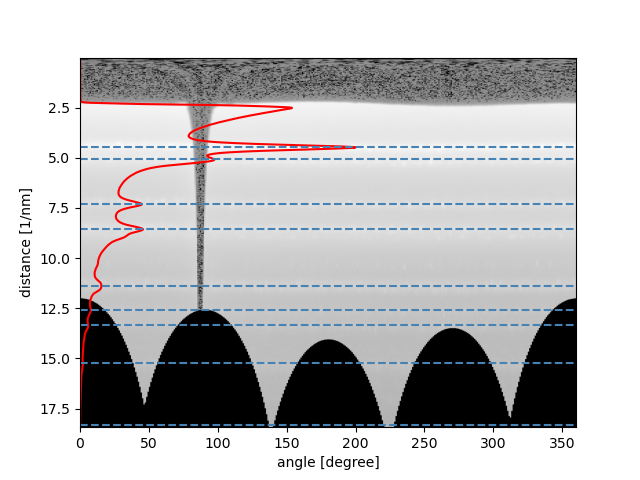

In [8]:
import scipy as sp
import scipy.signal as signal

scale = main_dataset.u.slope*4.28/3.75901247*1.005



# find_Bragg peaks in profile
peaks, g= signal.find_peaks(tags['radial_average'],rel_height =0.7, width=7)  # np.std(second_deriv)*9)

print(peaks*scale)

tags['ring_radii_px'] = peaks


plt.figure()

plt.imshow(log_polar,extent=(0,360,tags['polar_projection'].shape[0]*scale,scale),cmap='gray')

ax = plt.gca()
ax.set_aspect("auto");
plt.xlabel('angle [degree]');
plt.ylabel('distance [1/nm]')

plt.plot(tags['radial_average']/tags['radial_average'].max()*200,
         np.linspace(1,len(tags['radial_average']),len(tags['radial_average']))*scale,
         c='r')
for i in peaks:
    if i*scale > 3.5:
        plt.plot((0,360),(i*scale,i*scale), linestyle='--', c = 'steelblue')

## Calculate Ring Pattern

see [Structure Factors notebook ](CH2_04-Structure_Factors.ipynb) for details.

In [9]:
import itertools
# Initialize the dictionary with all the input
atoms = pyTEMlib.crystal_tools.structure_by_name('gold')

main_dataset.structures['Structure_000'] = atoms


reciprocal_unit_cell = atoms.cell.reciprocal() # transposed of inverted unit_cell

#INPUT
hkl_max = 7#  maximum allowed Miller index

acceleration_voltage = 200.0 *1000.0 #V
wave_length  = pyTEMlib.diffraction_tools.get_wavelength(acceleration_voltage)


h  = np.linspace(-hkl_max,hkl_max,2*hkl_max+1)   # all to be evaluated single Miller Index
hkl  = np.array(list(itertools.product(h,h,h) )) # all to be evaluated Miller indices
g_hkl = np.dot(hkl,reciprocal_unit_cell)  

# Calculate Structure Factors

structure_factors = []

base = atoms.positions # in Carthesian coordinates
for j  in range(len(g_hkl)):
    F = 0
    for b in range(len(base)):
        f = pyTEMlib.diffraction_tools.feq(atoms[b].symbol,np.linalg.norm(g_hkl[j])) # Atomic form factor for element and momentum change (g vector)
        F += f * np.exp(-2*np.pi*1j*(g_hkl[j]*base[b]).sum())        
    structure_factors.append(F)
F = structure_factors = np.array(structure_factors)

# Allowed reflections have a non zero structure factor F (with a  bit of numerical error)
allowed = np.absolute(structure_factors) > 0.001

distances = np.linalg.norm(g_hkl, axis = 1)

print(f' Of the evaluated {hkl.shape[0]} Miller indices {allowed.sum()} are allowed. ')
# We select now all the 
zero = distances == 0.
allowed = np.logical_and(allowed,np.logical_not(zero))

F = F[allowed]
g_hkl = g_hkl[allowed]
hkl = hkl[allowed]
distances = distances[allowed]

sorted_allowed = np.argsort(distances)

distances = distances[sorted_allowed]
hkl = hkl[sorted_allowed]
F = F[sorted_allowed]

# How many have unique distances and what is their muliplicity

unique, indices  = np.unique(distances, return_index=True)

print(f' Of the {allowed.sum()} allowed Bragg reflections there are {len(unique)} families of reflections.')

intensity = np.absolute(F[indices]**2*(np.roll(indices,-1)-indices))
print('\n index \t  hkl \t      1/d [1/Ang]       d [pm]     F      multip.  intensity' )
family = []
out_tags = {}
reflection = 0
for j in range(len(unique)-1):
    i = indices[j]    
    i2 = indices[j+1]   
    family.append(hkl[i+np.argmax(hkl[i:i2].sum(axis=1))])
    index = '{'+f'{family[j][0]:.0f} {family[j][1]:.0f} {family[j][2]:.0f}'+'}'
    print(f'{i:3g}\t {index} \t  {distances[i]:.2f}  \t {1/distances[i]*100:.0f} \t {np.absolute(F[i]):4.2f} \t  {indices[j+1]-indices[j]:3g} \t {intensity[j]:.2f}') 
    #out_tags['reflections'+str(reflection)]={}
    out_tags['reflections-'+str(reflection)+'-index'] = index
    out_tags['reflections-'+str(reflection)+'-recip_distances'] = distances[i]
    out_tags['reflections-'+str(reflection)+'-structure_factor'] = np.absolute(F[i])
    out_tags['reflections-'+str(reflection)+'-multiplicity'] = indices[j+1]-indices[j]
    out_tags['reflections-'+str(reflection)+'-intensity'] = intensity[j]
    reflection +=1

C:\Users\gduscher\AppData\Local\Temp\ipykernel_27544\2803577142.py:29: DeprecationWarning: feq is deprecated, please use form_factor instead
  f = pyTEMlib.diffraction_tools.feq(atoms[b].symbol,np.linalg.norm(g_hkl[j])) # Atomic form factor for element and momentum change (g vector)


 Of the evaluated 3375 Miller indices 855 are allowed. 
 Of the 854 allowed Bragg reflections there are 39 families of reflections.

 index 	  hkl 	      1/d [1/Ang]       d [pm]     F      multip.  intensity
  0	 {1 1 1} 	  0.42  	 235 	 27.00 	    8 	 5832.86
  8	 {0 0 2} 	  0.49  	 204 	 24.48 	    6 	 3596.79
 14	 {0 2 2} 	  0.69  	 144 	 18.27 	   12 	 4004.58
 26	 {1 1 3} 	  0.81  	 123 	 15.54 	    8 	 1930.91
 34	 {1 3 1} 	  0.81  	 123 	 15.54 	   16 	 3861.82
 50	 {2 2 2} 	  0.85  	 118 	 14.82 	    8 	 1756.96
 58	 {0 0 4} 	  0.98  	 102 	 12.57 	    6 	 948.09
 64	 {3 3 1} 	  1.07  	 94 	 11.33 	    8 	 1026.40
 72	 {3 1 3} 	  1.07  	 94 	 11.33 	   16 	 2052.80
 88	 {4 0 2} 	  1.10  	 91 	 10.97 	   24 	 2889.10
112	 {2 2 4} 	  1.20  	 83 	 9.77 	   24 	 2291.50
136	 {5 1 1} 	  1.27  	 78 	 9.05 	   16 	 1310.07
152	 {3 3 3} 	  1.27  	 78 	 9.05 	   16 	 1310.07
168	 {0 4 4} 	  1.39  	 72 	 8.08 	   12 	 783.51
180	 {1 5 3} 	  1.45  	 69 	 7.60 	   48 	 2775.70
228	 {4 4 2

In [10]:
# -----Input for ring pattern calculation ----
structure = 'gold'
hkl_max = 7
verbose = True
# --------------------------------------------

atoms = pyTEMlib.crystal_tools.structure_by_name(structure)
main_dataset.structures['Structure_000'] = atoms
main_dataset.metadata['experiment']['hkl_max']  = hkl_max

pyTEMlib.diffraction_tools.ring_pattern_calculation(main_dataset, verbose=verbose)


Of the 3374 possible reflection 854 are allowed.
Of the 854 allowed reflection 33  have unique distances.


 [hkl]  	 1/d [1/nm] 	 d [nm] 	 F^2 
[1. 1. 1.] 	 4.25 	         0.2355 	 729.11 
[0. 0. 2.] 	 4.90 	         0.2039 	 599.47 
[2. 0. 2.] 	 6.94 	         0.1442 	 333.71 
[1. 1. 3.] 	 8.13 	         0.1230 	 241.36 
[2. 2. 2.] 	 8.49 	         0.1177 	 219.62 
[0. 0. 4.] 	 9.81 	         0.1020 	 158.02 
[3. 3. 1.] 	 10.69 	         0.0936 	 128.30 
[2. 0. 4.] 	 10.97 	         0.0912 	 120.38 
[4. 2. 2.] 	 12.01 	         0.0832 	 95.48 
[3. 3. 3.] 	 12.74 	         0.0785 	 81.88 
[4. 0. 4.] 	 13.87 	         0.0721 	 65.29 
[5. 1. 3.] 	 14.51 	         0.0689 	 57.83 
[4. 4. 2.] 	 14.71 	         0.0680 	 55.65 
[0. 2. 6.] 	 15.51 	         0.0645 	 48.14 
[5. 3. 3.] 	 16.08 	         0.0622 	 43.55 
[2. 2. 6.] 	 16.27 	         0.0615 	 42.17 
[4. 4. 4.] 	 16.99 	         0.0589 	 37.33 
[5. 1. 5.] 	 17.51 	         0.0571 	 34.26 
[0. 4. 6.] 	 17.68 	         0.0566 	 33.33

## Comparison
Comparison between experimental profile and kinematic theory

The grain size will have an influence on the width of the diffraction rings"

C:\Users\gduscher\AppData\Local\anaconda3\Lib\site-packages\matplotlib\cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\gduscher\AppData\Local\anaconda3\Lib\site-packages\matplotlib\cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


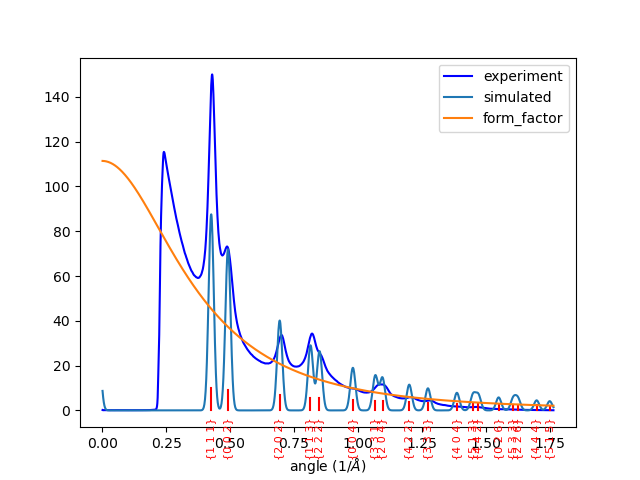

In [11]:
# -------Input of grain size ----
resolution  = .0001 # 1/nm
thickness = 100 # Ang
elements = ['Au', 'C']
# -------------------------------
import scipy

def plot_diffraction_profile(dataset, resolution, thickness, elements=[]):
    tags = dataset.metadata.get('diffraction', {})
    if not tags:
        print("No diffraction metadata found.")
        return  
    unique = tags['Ring_Pattern']['allowed']['g norm']
    family = tags['Ring_Pattern']['allowed']['hkl']
    intensity = np.array(tags['Ring_Pattern']['allowed']['structure_factor'])

    scale = main_dataset.get_image_dims(return_axis=True)[0].slope*1.085*1.0/10*1.01

    width = (1/thickness + resolution) / scale
    
    intensity2 = intensity/intensity.max()*10

    profile = tags['radial_average']
    gauss = scipy.signal.windows.gaussian(len(profile), std=width)
    simulated_profile = np.zeros(len(profile))
    reciprocal_dist = np.linspace(1,len(profile),len(profile))*scale

    x  =[]
    form_factors = np.zeros((len(elements), len(reciprocal_dist)))
    for j, element in enumerate(elements):
        for i, r_dist in enumerate(reciprocal_dist):
            form_factors[j,i] = pyTEMlib.diffraction_tools.form_factor(element, r_dist)
    yAu = form_factors[elements.index('Au')]
    plt.figure()
    plt.plot(reciprocal_dist,profile/profile.max()*150, color='blue', label='experiment');
    for j in range(len(unique)-1):
        if unique[j] < len(profile)*scale:
            # plot lines
            
            plt.plot([unique[j],unique[j]], [0, intensity2[j]],c='r')
            # plot indices
            index = '{'+f'{family[j][0]:.0f} {family[j][1]:.0f} {family[j][2]:.0f}'+'}' # pretty index string
            plt.text(unique[j],-3, index, horizontalalignment='center',
                verticalalignment='top', rotation = 'vertical', fontsize=8, color = 'red')
            
            # place Gaussian with appropriate width in profile
            g = np.roll(gauss,int(-len(profile)/2+unique[j]/scale))* intensity2[j]*np.array(yAu)*1.3#rec_dist**2*10
            simulated_profile = simulated_profile + g
    plt.plot(np.linspace(1,len(profile),len(profile))*scale,simulated_profile, label='simulated');
    plt.plot(reciprocal_dist,np.array(yAu)**2, label='form_factor')
    plt.xlabel(r'angle (1/$\AA$)')
    plt.legend()
#plt.ylim(-35,210);

# pyTEMlib.diffraction_tools.
plot_diffraction_profile(main_dataset, resolution, thickness, elements)

## Publication Quality Output

Now we have all the ingredients to make a publication quality plot of the data.

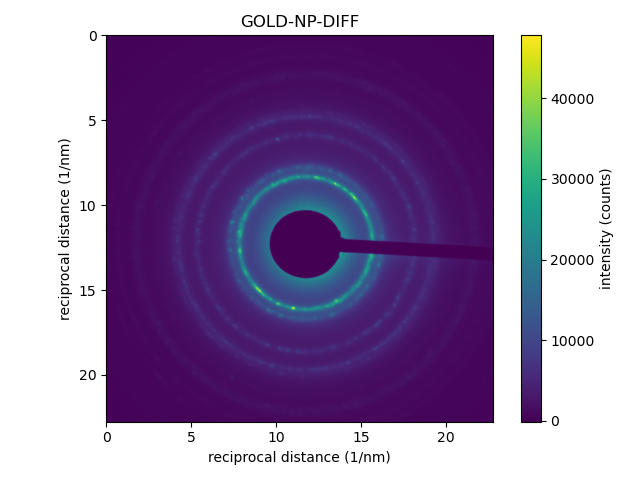

In [12]:
# pyTEMlib.diffraction_tools.
import sidpy
def set_center(main_dataset, center, scale=scale):
    if isinstance(scale, float):
        scale = (scale, scale)
    x_axis = np.linspace(0, main_dataset.shape[0]-1, main_dataset.shape[0])-center[1]
    x_axis *= scale[0]
    y_axis = np.linspace(0, main_dataset.shape[1]-1, main_dataset.shape[1])-center[0]
    y_axis *= -scale[1]
    x = sidpy.Dimension(name='u', values=x_axis)
    
    main_dataset.set_dimension(0, sidpy.Dimension(name='u', values=x_axis, units='1/nm',
                                                  dimension_type='spatial', quantity='reciprocal distance'))
    main_dataset.set_dimension(1, sidpy.Dimension(name='v', values=y_axis, units='1/nm',
                                                  dimension_type='spatial', quantity='reciprocal distance'))

v =main_dataset.plot()


C:\Users\gduscher\AppData\Local\anaconda3\Lib\site-packages\matplotlib\cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\gduscher\AppData\Local\anaconda3\Lib\site-packages\matplotlib\cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


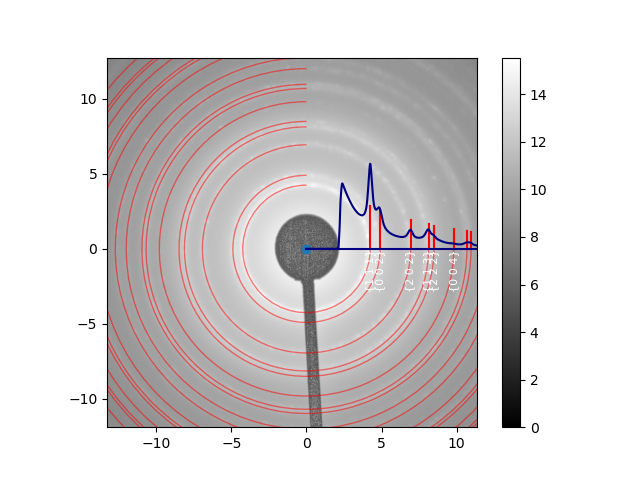

In [17]:
scale = main_dataset.get_image_dims(return_axis=True)[0].slope
pyTEMlib.diffraction_tools.set_center(main_dataset, center, scale=scale*1.01)
v = pyTEMlib.diffraction_tools.plot_ring_pattern(main_dataset.metadata['diffraction'], main_dataset)

In [ ]:
from matplotlib import patches

tags = main_dataset.metadata.get('diffraction', {})
if not tags:
    print("No diffraction metadata found.")
    # return  
diff_pattern = main_dataset
unique = tags['Ring_Pattern']['allowed']['g norm']*10*1.05
family = tags['Ring_Pattern']['allowed']['hkl']
intensity = np.array(tags['Ring_Pattern']['allowed']['structure_factor'])

scale = main_dataset.get_image_dims(return_axis=True)[0].slope# *1.085*1.0/10*1.01*10

width = (1/thickness + resolution) / scale



profile = tags['radial_average']

fig = plt.figure(figsize=(9, 6)) 

extent= main_dataset.get_extent([0,1])
# np.array([-center[0], diff_pattern.shape[0]-center[0],-diff_pattern.shape[1]+center[1], center[1]])*scale# *1.005
profile *=  extent[1]*0.5 /profile.max()
intensity2 = intensity/intensity.max()*extent[1]/4

plt.imshow(np.log2(1+diff_pattern.T),cmap='gray', extent=(extent*1.0))
plt.xlabel(r'reciprocal distance [nm$^{-1}$]')
ax = fig.gca()
#ax.add_artist(circle1);
plt.plot(np.linspace(1,len(profile),len(profile))*scale,profile, color='y')
plt.plot((0,len(profile)*scale),(0,0),c='r')
# intensity2 = intensity/intensity.max()*(profile/profile.max())/2


for j in range(len(unique)-1):
    if unique[j] < len(profile)*scale:
        # plot lines
        plt.plot([unique[j],unique[j]], [0, intensity2[j]],c='r')
        arc = patches.Arc((0,0), unique[j]*2, unique[j]*2, 
                          angle=90.0, 
                          theta1=0.0, theta2=270.0, 
                          color='r', fill= False, alpha = 0.5)
        ax.add_artist(arc)
plt.scatter(0,0)
plt.xlim(extent[0], extent[1])
for i in range(6):
    index = '{'+f'{family[i][0]:.0f} {family[i][1]:.0f} {family[i][2]:.0f}'+'}' # pretty index string
    plt.text(unique[i],-0.05, index, horizontalalignment='center',
             verticalalignment='top', rotation = 'vertical', fontsize=8, color = 'white')

In [ ]:
for j, ring in enumerate(unique):
    
    if ring < len(profile)*scale:
        plt.plot([ring[0],ring[1]], [0, intensity2[j]],c='r')
        arc = patches.Arc((0,0), distances[i]*2, distances[i]*2, 
                          angle=90.0, 
                          theta1=0.0, theta2=270.0, 
                          color='r', fill= False, alpha = 0.5)
        ax.add_artist(arc);
plt.scatter(0,0)

for i in range(6):
    index = '{'+f'{family[i][0]:.0f} {family[i][1]:.0f} {family[i][2]:.0f}'+'}' # pretty index string
    plt.text(unique[i],-0.05, index, horizontalalignment='center',
             verticalalignment='top', rotation = 'vertical', fontsize=8, color = 'white')

In [ ]:
plt.close('all')

In [ ]:
# pyTEMlib.diffraction_tools.
import sidpy
def set_center(main_dataset, center, scale=scale):
    if isinstance(scale, float):
        scale = (scale, scale)
    x_axis = np.linspace(0, main_dataset.shape[0]-1, main_dataset.shape[0])-center[1]
    x_axis *= scale[0]
    y_axis = np.linspace(0, main_dataset.shape[1]-1, main_dataset.shape[1])-center[0]
    y_axis *= -scale[1]
    x = sidpy.Dimension(name='u', values=x_axis)
    
    main_dataset.set_dimension(0, sidpy.Dimension(name='u', values=x_axis, units='1/nm',
                                                  dimension_type='spatial', quantity='reciprocal distance'))
    main_dataset.set_dimension(1, sidpy.Dimension(name='v', values=y_axis, units='1/nm',
                                                  dimension_type='spatial', quantity='reciprocal distance'))
set_center(main_dataset, center, scale=scale)
v =main_dataset.plot()


In [ ]:
pyTEMlib.diffraction_tools.plot_ring_pattern(main_dataset.metadata['diffraction'], main_dataset)

In [ ]:
main_dataset.get_extent([0,1])

### Quiz

What would the figure caption for above figure be?

### What does the above figure convey?
* center is determined accurately
* relative distances are accurately described
* scaling accurately for reference crystal - calibration?

### What is the accuracy?

Change the scale by 1% and see what happens

So we can determine the lattce parameter better than 1% if we use high scattering angles!

## Logging the results

In [ ]:
out_tags['analysis'] = 'Indexing_Diffraction_Rings'
out_tags['scale'] = scale
main_dataset.metadata

In [ ]:
h5_group = pyTEMlib.file_tools.save_dataset(datasets, filename='Gold_SAED.hf5')
h5_group.file.close()

## Conclusion

We only need the scatterng factors to calculate the ring pattern.

A comparison between simulation and experiment can be very precise.

Normally one would do a fit of the most prominent peaks to establish the scale.

## Navigation
- <font size = "3">  **Back: [Structure Factors](CH2_04-Structure_Factors.ipynb)** </font>
- <font size = "3">  **Next: [Scttering Geometry](CH2_06-Kinematic_Scattering_Geometry.ipynb)** </font>
- <font size = "3">  **Chapter 2: [Diffraction](CH2_00-Diffraction.ipynb)** </font>
- <font size = "3">  **List of Content: [Front](../_MSE672_Intro_TEM.ipynb)** </font>

## Appendix

Opening the hdf5 file and plot the data again

### Open hf5 file

In [ ]:
new_dataset = ft.open_file(current_filename)

### And Plot

Because we saved all the results in all steps, it is straight forward to retrieve the publication quality plot again.

In [ ]:
## Access the data of the loaded image


diff_pattern = np.array(new_dataset)
diff_pattern = diff_pattern-diff_pattern.min()
current_channel = new_dataset.h5_dataset.parent.parent
result_group = current_channel['Log_000']

center = result_group['center'][()]
scale = result_group['scale'][()]

from matplotlib import patches
fig = plt.figure(figsize=(9, 6)) 
ax = plt.gca()
extent= np.array([-center[0], diff_pattern.shape[0]-center[0],-diff_pattern.shape[1]+center[1], center[1]])*scale

plt.imshow(np.log2(1+diff_pattern).T, cmap="gray", extent=(extent), vmin=np.max(np.log2(1+diff_pattern))*0.5)
plt.xlabel(r'reciprocal distance [nm$^{-1}$]')

profile = result_group['radial_average'][()]
plt.plot(np.linspace(1,len(profile),len(profile))*scale,profile/profile.max()*10, color='y');#
plt.plot((0,len(profile)*scale),(0,0),c='r')
reflections = {}
for key in result_group:
    if 'reflection' in key:
        keys = key.split('-')
        
        if keys[1] not in reflections:
            reflections[keys[1]]={}
        reflections[keys[1]][keys[2]] =  result_group[key][()]
        #print( reflections[keys[1]][keys[2]] )
for key in reflections:
    distance = reflections[key]['recip_distances']
    if distance < len(profile)*scale:
        
        plt.plot([distance,distance], [0, reflections[key]['intensity']/1000],c='r')
        arc = patches.Arc((0,0), distance*2, distance*2, angle=90.0, theta1=0.0, theta2=270.0, color='r', fill= False, alpha = 0.5)#, **kwargs)
        ax.add_artist(arc);
plt.scatter(0,0);
for i in range(7):
    index = reflections[str(i)]['index'] # pretty index string
    plt.text(unique[i],-0.5, index, horizontalalignment='center',
          verticalalignment='top', rotation = 'vertical', fontsize=8, color = 'white')

### 3D Plot of Miller Indices

In [ ]:
hkl_max = 4
h  = np.linspace(-hkl_max,hkl_max,2*hkl_max+1)  # all evaluated single Miller Indices
hkl  = np.array(list(itertools.product(h,h,h) )) # all evaluated Miller indices

# Plot 2D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(hkl[:,0], hkl[:,2], hkl[:,1], c='red', s=10)
plt.xlabel('h')
plt.ylabel('l')
fig.gca().set_zlabel('k')
#ax.set_aspect('equal')

## Reciprocal Space and Miller Indices

For a reciprocal cubic  unit cell with lattice parameter $b = \frac{1}{a}$:

$$	
\vec{g}_{hkl} = \begin{pmatrix}h\\k\\l\end{pmatrix}  \cdot	\begin{pmatrix}b&0&0\\0&b&0\\0&0&b\end{pmatrix} 
$$			

Or more general
			
$$			
\vec{g}_{hkl} = \begin{pmatrix}h\\k\\l\end{pmatrix} \cdot 	\begin{pmatrix}b_{1,1}&b_{1,2}&b_{1,3}\\b_{2,1}&b_{2,2}&b_{2,3}\\b_{3,1}&b_{3,2}&b_{3,3}\end{pmatrix} 
$$


The matrix is of course the reciprocal unit cell or the inverse of the structure matrix.

Therefore, we get any reciprocal lattice vector with the dot product of its Miller indices and the reciprocal lattice matrix.




Spacing of planes with Miller Indices $hkl$
$$			\begin{align*}
			|\vec{g}_{hkl}|& = \frac{1}{d}\\
			d &= \frac{1}{|\vec{g}_{hkl}|}
			\end{align*}$$
			
The length of a vector is called its **norm**.


Be careful there are two different notations for the reciprocal lattice vectors:
- materials science 
- physics

The notations are different in a factor $2\pi$.  The introduction of  $2\pi$ in physics allows to take care of the $n$ more naturally.

In the materials science notation the reciprocal lattice points are directly associated with the Bragg reflections in your diffraction pattern. <br>
(OK,s we are too lacy to keep track of $2\pi$)

### All Possible Reflections

Are then given by the all permutations of the Miller indices and the reiprocal unit cell matrix.

All considered Miller indices are then produced with the itertool package of python.


In [ ]:

hkl_max = 9#  maximum allowed Miller index

h  = np.linspace(-hkl_max,hkl_max,2*hkl_max+1)   # all evaluated single Miller Indices
hkl  = np.array(list(itertools.product(h,h,h) )) # all evaluated Miller indices
g_hkl = np.dot(hkl,reciprocal_unit_cell)         # all evaluated reciprocal lattice points

print(f'Evaluation of {g_hkl.shape} reflections of {hkl.shape} Miller indices')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(g_hkl[:,0], g_hkl[:,2], g_hkl[:,1], c='red', s=10)
plt.xlabel('u')
plt.ylabel('v')
fig.gca().set_zlabel('w')


### Atomic form factor

If we look at the scattering power of a single atom that deflects an electron:
    
![Single atom scattering](images/scattering_single_atom.jpg)

See [Atomic Form Factor](CH2_02-Atomic_Form_Factor.ipynb) for details

## Calculate Structure Factors 

To extend the single atom view of the atomic form factor $f(\theta$)  to a crystal, we change to the structure factor $F(\theta)$. The structure factor  $F(\theta)$ is a measure
of the amplitude scattered by a unit cell of a crystal
structure. 

Because $F(\theta)$ is an amplitude like  $f(\theta)$, it also
has dimensions of length.We can define  $F(\theta)$ as: 
$$ F_{hkl}(\theta) = \sum_{j=1}^{\inf} f_i(\theta) \mathrm{e}^{[-2 \pi i (h x_j+k y_j + l z_j)]} 
$$

The sum is over all the $i$ atoms in the unit cell (with
atomic coordinates $x_i, y_i, z_i$ 

The structure factors $f_i(\theta)$ are multiplied by a phase factor (the exponential function).
The phase factor takes account of the difference in phase
between waves scattered from atoms on different but
parallel atomic planes with the same Miller indices$ (hkl)$.

The scattering angle $\theta$  is the angle between the angle between the incident
and scattered electron beams.


Please identify all the variables in line 10 below. Please note that we only do a finite number of hkl

In [ ]:
# Calculate Structure Factors

structure_factors = []

base = np.dot(tags['base'],tags['unit_cell'])  # transformation from relative to Carthesian coordinates
for j  in range(len(g_hkl)):
    F = 0
    for b in range(len(base)):
        f = ks.feq(tags['elements'][b],np.linalg.norm(np.dot(g_hkl[j], reciprocal_lattice))) # Atomic form factor for element and momentum change (g vector)
        F += f * np.exp(-2*np.pi*1j*(g_hkl[j]*base[b]).sum())        
    structure_factors.append(F)
F = structure_factors = np.array(structure_factors)


### All Allowed Reflections

The structure factor determines whether a reflection is allowed or not.

If the structure factor is zero, the reflection is called forbidden.

In [ ]:
# Allowed reflections have a non zero structure factor F (with a  bit of numerical error)
allowed = np.absolute(structure_factors) > 0.001

print(f' Of the evaluated {hkl.shape[0]} Miller indices {allowed.sum()} are allowed. ')

distances = np.linalg.norm(g_hkl, axis = 1)
# We select now all the 
zero = distances == 0.
allowed = np.logical_and(allowed,np.logical_not(zero))

F = F[allowed]
g_hkl = g_hkl[allowed]
hkl = hkl[allowed]
distances = distances[allowed]


### Families of reflections

reflections with the same length of reciprocal lattice vector are called families

In [ ]:
sorted_allowed = np.argsort(distances)

distances = distances[sorted_allowed]
hkl = hkl[sorted_allowed]
F = F[sorted_allowed]

# How many have unique distances and what is their muliplicity

unique, indices  = np.unique(distances, return_index=True)

print(f' Of the {allowed.sum()} allowed Bragg reflections there are {len(unique)} families of reflections.')


### Intensities and Multiplicities


In [ ]:
multiplicitity = np.roll(indices,-1)-indices
intensity = np.absolute(F[indices]**2*multiplicitity)
print('\n index \t     hkl \t 1/d [1/nm]     d [pm] \t  F \t multip. intensity' )
family = []
for j in range(len(unique)-1):
    i = indices[j]    
    i2 = indices[j+1]   
    family.append(hkl[i+np.argmax(hkl[i:i2].sum(axis=1))])
    print(f'{i:3g}\t {family[j]} \t  {distances[i]:.2f}  \t {1/distances[i]*1000:.0f} \t {np.absolute(F[i]):.2f}, \t  {indices[j+1]-indices[j]:3g} \t {intensity[j]:.2f}') 
    


## Allowed reflections for Silicon:   
$\ \ |F_{hkl}|^2 =  \begin{cases} (  h , k , l \ \ \mbox{ all odd} &\\
                    (  h ,| k , l \ \  \mbox{all even}& \mbox{and}\ \ h+k+l = 4n\end{cases}$ 

Check above allowed reflections whether this condition is met for the zero order Laue zone.


Please note that the forbidden and alowed reflections are directly a property of the structure factor.

## Diffraction with Parallel Illumination 

Polycrystalline Sample  |Single Crystalline Sample
:---------:|:-----------------:
ring pattern |spot pattern
depends on $F(\theta)$ | depends on $F(\theta)$ 
		| depends on excitation error $s$

## Ring Pattern
<img src="images/CL375.jpg" alt="Bragg's Law" width="300" >
<img src="images/ProfileOfCL375.jpg" alt="Bragg's Law" width="300" >

**Ring Pattern:**
- The profile of a ring diffraction pattern (of a polycrystalline sample) is very close to what a you are used from X-ray diffraction.
- The x-axis is directly the magnitude of the $|\vec{g}| = 1/d$ of a hkl plane set.
	
- The intensity of a Bragg reflection is directly related to the square of the structure factor $I = F^2(\theta)$
	
- The intensity of a ring is directly related to the multiplicity of the family of planes. 


**Ring Pattern Problem:**
-  Where is the center of the ring pattern
- Integration over all angles (spherical coordinates)
- Indexing of pattern is analog to x-ray diffraction. 

The Ring Diffraction Pattern are completely defined by the Structure Factor

In [ ]:
from matplotlib import patches
fig, ax = plt.subplots()
plt.scatter(0,0);
img = np.zeros((1024,1024))
extent = np.array([-1,1,-1,1])*np.max(unique)
plt.imshow(img, extent = extent)

for radius in unique:   
    circle = patches.Circle((0,0), radius*2, color='r', fill= False, alpha = 0.3)#, **kwargs)
    ax.add_artist(circle);


## Conclusion
The scattering geometry provides all the tools to determine which reciprocal lattice points are possible and which of them are allowed.

Next we need to transfer out knowledge into a  diffraction pattern.

## Navigation

- <font size = "3">  **Back: [Basic Crystallography](CH2_04-Structure_Factors.ipynb)** </font>
- <font size = "3">  **Next: [Kinematic Scattering Geometry](CH2_06-Kinematic_Scattering_Geometry.ipynb)** </font>
- <font size = "3">  **Chapter 2: [Diffraction](CH2_00-Diffraction.ipynb)** </font>
- <font size = "3">  **List of Content: [Front](../_MSE672_Intro_TEM.ipynb)** </font>

